## Water balance model

This notebook explains how to create a water balance model for a small lake (farm dam) in Australia. We use the measurements in an Excel file. The figure below is a schematic representation of our water balance model. There are three fluxes: precipitation, evaporation and infiltration. The infiltration flux represents the flow of water from the lake to the groundwater.

<p align="center">
<img src="figure/water_balance.png" alt="drawing" width="200"/>
</p>

In [46]:
# import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
# read the data from excel using pandas
df = pd.read_excel('data/water_balance_data.xlsx',
                   index_col=0,
                   parse_dates=True)
df.head()

,temperature,rh,rain,wl,volume,area,vpd,evaporation,Cl_sample
2013-08-25,11.25,81.0,0.0,-0.481333,1188.982978,1309.122275,0.253591,4.580943,20.234657
2013-08-26,10.75,89.5,0.4,-0.491695,1175.444157,1302.024401,0.135561,2.642061,19.791141
2013-08-27,13.75,71.0,0.0,-0.498408,1166.708590,1297.418221,0.456128,4.454706,NaN
2013-08-28,14.00,83.0,0.0,-0.505052,1158.090844,1292.853550,0.271763,0.594952,NaN
2013-08-29,14.10,84.5,6.8,-0.505966,1156.907482,1292.225131,0.249396,1.930750,NaN


### Precipitation

We start with calculating the precipitation volumetric flow rate which is

$ P = P_{mm} / 1000 * A$

in which $P$ is the amount of rainfall added to the farm dam in m $^3$ /d, $P_{mm}$ the recorded daily rainfall in mm and $A$ is the water surface area m $^2$. Let's plot the required data.

<Axes: >

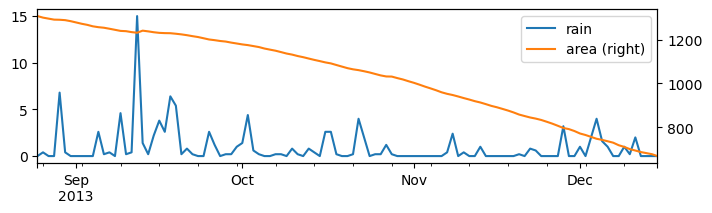

In [48]:
df[['rain', 'area']].plot(secondary_y='area', figsize=(8,2))

Use a `for` loop to get the rain flux for each timestep.

In [49]:
P = np.zeros(len(df))           # create an array with zeros and the same size as 'df'
for i in range(len(df)):
    P[i] = df['area'].iloc[i] * df['rain'].iloc[i] / 1000.0 
df['P'] = P               # create new column in the DataFrame with the rain in m3/d

Now that we have or rain flux as a column in the DataFrame we can plot the data.

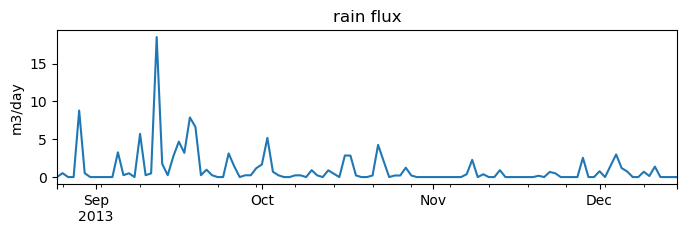

In [50]:
df['P'].plot(figsize=(8,2), ylabel='m3/day', title='rain flux');

### Evaporation
Now we calculate the evaporation contribution to the water balance. The evaporation measurements in the Excel represent daily values measured using a Class A evaporation pan. The conversion to a volumetric evaporation rate in m $^3$/d is

$ E = E_{mm} / 1000 / 1.2 * A$

in which $E$ is the evaporated amount of water in m $^3$ /d, $E_{mm}$ the recorded daily pan evaporation in mm. From the equation it can be seen that the pan factor was assumed to be 1.2.

In [51]:
pan_factor = 1.2                # assuming a pan factor of 1.3
E = np.zeros(len(df))           # create an array with zeros and the same size as 'df'
for i in range(len(df)):
    E[i] = df['area'].iloc[i] * df['evaporation'].iloc[i] / 1000.0 / pan_factor 
df['E'] = E               # create new column in the DataFrame with the evaporation in m3/d

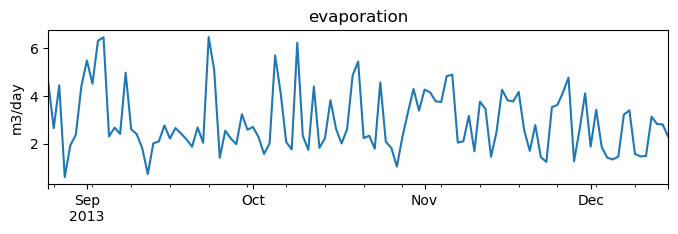

In [52]:
df['E'].plot(figsize=(8,2), ylabel='m3/day', title='evaporation');

### Infiltration

The infiltration was not measured directly. Therefore we use the precipitation and the evaporation fluxes together with the volume changes of the farm dam to calculate the infiltration flux as

$ I = P - E - dV$

Note that $P$ and $E$ are both positive numbers but $dV$ is negative when the water volume decreases between two consecutive days.

In [53]:

dV = np.zeros(len(df))                               # create array with volume changes in the lake
I = np.zeros(len(df))                                # create array for the infiltration
for i in range(len(df)-1):
    dV[i] =  df['volume'].iloc[i+1] - df['volume'].iloc[i]           # get change in lake volume per timestep
    I[i] = df["P"].iloc[i] - df["E"].iloc[i] - dV[i]

df['dV'] = dV                                                      # create new column in the DataFrame with the Volume changes
df['I'] = I                                   # create new column in the DataFrame with the infiltration

Now we have the water balance model and we can plot the results.

<Axes: >

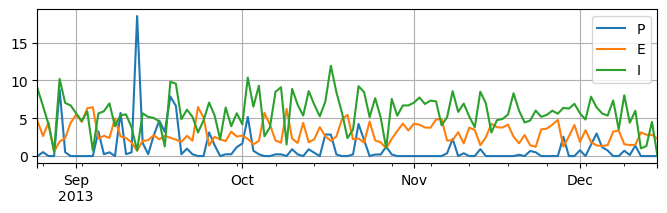

In [54]:
df[['P', 'E', 'I']].plot(figsize=(8,2), grid=True)

## Code optimisation

Now that we have the correct code for our water balance model we can start to optimise the code.

We start by calculating the rainfall in four different ways:
1. using the `for` loop, this is the same method as used her above
2. using a `for` loop with the iterrows function
3. using the `apply` method of a pandas DataFrame
4. using the vector operations for pandas DataFrames

We put the `%%timeit` code at the start of each cell to calculate the code execution time. This makes it easy to
compare the performance of the methods. Note that the computation times can vary significantly between machines, python versions, package versions (NumPy, Pandas) and operating systems.

In [55]:
%%timeit
#1 using a simple for loop

P = np.zeros(len(df))
for i in range(len(df)):
    P[i] = df['area'].iloc[i] * df['rain'].iloc[i] / 1000.0 

df['P'] = P

2.48 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
#2 using iterrows
df['P'] = np.nan                            # create an empty column in the dataframe with the rain 
for i, row in df.iterrows():
    P_i = row['area'] * row['rain'] / 1000.0  # calculate the rain flux for one timestap
    df.loc[i,'P'] = P_i               # assign the value to the column in the DataFrame

In [ ]:
%%timeit
#3 using the apply method

# define a function to calculate the rain flux
def get_P(row):
    return row['area'] * row['rain'] / 1000.0

# apply this function to every row in a Dataframe
df['P'] = df.apply(get_P, axis=1)

In [ ]:
%%timeit
#4 using a vector operation
df['P'] = df['area'] * df['rain'] / 1000

All the methods are pretty fast because our dataset is only 113 timesteps. However, you can see that there are large differences in computation times between the methods where the slowest method (3) is about 10 times slower than the fastest method (1).

We can also compare our methods using the 4 steps of Wes Dyer:

| method     | correct | clear | concise | fast |
|------------|---------|-------|---------|------|
| 1 for-loop | ✓       | x     | xx      | ✓   |
| 2 iterrows | ✓       | x     | x       | xx   |
| 3 apply    | ✓       | xx    | ✓       | x    |
| 4 vector   | ✓       | ✓✓    | ✓✓      | ✓✓    |

Note that this is an interpretation, especially 'clear' and 'concise' are very subjective criteria.

Method 4 is clearly the winner in this case. So we apply this method to the other calculations as well. We can use the `diff()` method to calculate the change in lake volume.

In [56]:
%%timeit
df['P'] = df['area'] * df['rain'] / 1000.
df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
df['dV'] = -df['volume'].diff(periods=-1)
df['I'] = df['P'] - df['E'] - df['dV']

1.12 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Can we make it even faster? By looking at the code we can see that both `df['rain']` and `df['evaporation']` are multiplied by `df['area']` and divided by 1000. We could define a variable that is equal to the area divided by 1000, and multiply the difference between rainfall and evaporation, reducing the number of arithmetic operations. Let's check if it makes a big difference. 

In [ ]:
%%timeit
f = df["area"] / 1000.
df['dV'] = -df['volume'].diff(periods=-1)
df['infiltration'] = (df['rain'] - df['evaporation'] * pan_factor) * f - df['dV']

It seems to be somewhat faster, but the code becomes a little less readable. Whether one weights up versus the other is a matter for debate.

Note that when a `for` loop can not be avoided, a significant speed-up can be achieved by converting the data to NumPy arrays. Let's have a look at the rainfall calculation once more and check the performance of the for loop but now using NumPy arrays.

In [ ]:
%%timeit
#1 using a simple for loop
rain = df['rain'].to_numpy()                # convert from a pandas dataframe to a numpy array
area = df['area'].to_numpy()                # convert from a pandas dataframe to a numpy array

P = np.zeros_like(rain)           # create an array with zeros and the same size as 'rain'
for i in range(len(P)):
    P[i] = area[i] * rain[i] / 1000.0  # calculate the rain flux for one timestap

df['P'] = P               # create new column in the DataFrame with the rain flux

Much faster than looping over the DataFrame and even faster than the vector operation with the DataFrame columns!

In [66]:
pan_factor = 1.3
Cl_0 = 20 # g/m^3 = mg/l
Cl_rain = 2 # g/m^3 = mg/l

df['P'] = df['area'] * df['rain'] / 1000.
df['E'] = df['area'] * df['evaporation'] / (1000. * pan_factor)
df['dV'] = -df['volume'].diff(periods=-1)
df['I'] = df['P'] - df['E'] - df['dV']

M_Cl_g = np.empty(len(df))
conc_Cl = np.empty(len(df))

P = df["P"].to_numpy()
I = df["I"].to_numpy()
V = df["volume"].to_numpy()
for i, (Vi, Pi, Ii) in enumerate(zip(V, P, I)):
    if i == 0: # First day
        M_Cl_g[0] = Vi * Cl_0
        conc_Cl[0] = M_Cl_g[0] / Vi # Gives Cl_0 of course!
    else:
        M_Cl_g[i] = M_Cl_g[i - 1] + dM_P - dM_I
        conc_Cl[i] = M_Cl_g[i] / Vi

    dM_P = Cl_rain * Pi
    dM_I = conc_Cl[i] * Ii

df["conc_Cl"] = conc_Cl

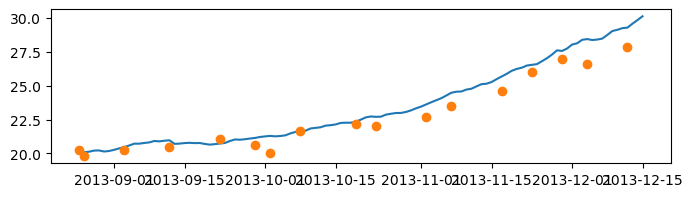

In [65]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df.index, df["conc_Cl"])
ax.plot(df.index, df["Cl_sample"], 'o')

In [75]:
from isotopes import Isotope

P = df["P"].to_numpy()
I = df["I"].to_numpy()
E = df["E"].to_numpy()
V = df["volume"].to_numpy()
Tc = df["temperature"].to_numpy()
RH = df["rh"].to_numpy() / 100.

O18 = Isotope("18O")
delta_18O_0 = -3.75
delta_18O_rain = -3.75
delta_18O_atm = -17

M_18O = np.empty(len(df))
delta_18O = np.empty(len(df))

for i, (Vi, Pi, Ei, Ii, Tci, RHi) in enumerate(zip(V, P, E, I, Tc, RH)):
    if i == 0: # First day
        M_18O[0] = Vi * delta_18O_0
        delta_18O[0] = M_18O[0] / Vi # Gives delta_18O_0 of course!
    else:
        M_18O[i] = M_18O[i - 1] + dM_P -dM_E - dM_I
        delta_18O[i] = M_18O[i] / Vi    

    dM_P = delta_18O_rain * Pi
    dM_E = O18.delta_e(Tci, RHi, delta_18O[i], delta_18O_atm) * Ei
    dM_I = delta_18O[i] * Ii

df["delta_18O"] = delta_18O

0.81
0.895
0.71
0.83
0.845
0.87
0.7
0.64
0.77
0.55
0.32
0.91
0.895
0.81
0.595
0.685
0.79
0.845
0.815
0.905
0.92
0.6
0.835
0.865
0.755
0.84
0.765
0.865
0.9
0.48
0.705
0.86
0.7
0.7
0.79
0.505
0.545
0.66
0.775
0.88
0.615
0.39
0.815
0.875
0.835
0.275
0.805
0.8
0.65
0.745
0.765
0.7
0.405
0.695
0.555
0.24
0.25
0.77
0.87
0.82
0.695
0.86
0.735
0.63
0.75
0.7
0.695
0.75
0.6
0.62
0.65
0.65
0.485
0.245
0.8
0.83
0.665
0.785
0.74
0.77
0.715
0.68
0.76
0.755
0.735
0.575
0.625
0.81
0.72
0.825
0.825
0.685
0.44
0.36
0.285
0.815
0.725
0.51
0.485
0.685
0.665
0.73
0.73
0.85
0.56
0.38
0.77
0.72
0.85
0.76
0.785
0.69
0.745


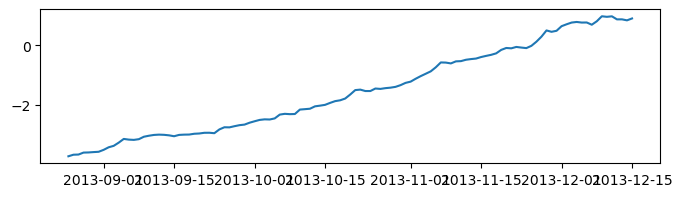

In [73]:
fig, ax = plt.subplots(figsize=(8,2))
ax.plot(df.index, df["delta_18O"])